# Exercise 2: Optimize transformer attention for GPU throughput

You have learned about hardware-aware architecture design and efficient patterns in theory. Now it's time to apply these concepts by implementing and comparing different attention architectures to maximize GPU throughput.

> **Overview**: A transformer model is struggling with throughput bottlenecks during peak traffic. While the model achieves excellent accuracy, the attention mechanism is not effectively using the memory bandwidth and under-utilizing the T4's parallel processing capabilities.
> 
> **Scenario**: You work for a social media platform that processes millions of posts for content moderation in real-time. Your current BERT-base model processes only 350 samples/second on T4 GPUs, but you need 1000+ samples/second to handle peak traffic loads. The DevOps team reports that GPU utilization is surprisingly low (15-25%), suggesting the architecture isn't designed for efficient parallel processing.
> 
> **Goal**: Learn to design and implement memory-efficient attention patterns that leverage GPU parallelism, comparing Multi-Head Attention (MHA) vs Multi-Query Attention (MQA) architectures, and apply hardware-specific optimizations like mixed precision to maximize T4 throughput.
> 
> **Tools**: pytorch, transformers, amp (mixed precision), datasets
> 
> **Estimated Time**: 15 minutes

# Step 1: Setup 

Let's establish our baseline environment and verify T4 capabilities for attention optimization.

In [1]:
# # Uncomment to install necessary libraries, then comment out the cell block again and restart the notebook
# ! pip install transformers datasets

In [2]:
# Import core libraries
import os
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from datasets import load_dataset
from transformers import AutoTokenizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime
import math

# Create output directory, if it does not exists
output_dir = "assets/exercise2"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check T4 GPU capabilities
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_properties = torch.cuda.get_device_properties(0)
    
    print(f"GPU: {gpu_name}")
    print(f"Compute Capability: {gpu_properties.major}.{gpu_properties.minor}")
    print(f"Total Memory: {gpu_properties.total_memory / 1e9:.1f} GB")
    print(f"Multiprocessors: {gpu_properties.multi_processor_count}")
    print(f"Memory Bandwidth: ~320 GB/s (theoretical)")
    
    # Check for Tensor Core support (Compute Capability >= 7.0)
    tensor_cores_available = gpu_properties.major >= 7
    print(f"Tensor Core Support: {'✓ Available' if tensor_cores_available else '✗ Not Available'}")
    
    if tensor_cores_available:
        print("  → Mixed precision (FP16) will show significant speedup")
        
    print("Setup complete!")
else:
    print("CUDA not available - exercise requires GPU")

print("Environment setup complete!")

GPU: Tesla T4
Compute Capability: 7.5
Total Memory: 15.6 GB
Multiprocessors: 40
Memory Bandwidth: ~320 GB/s (theoretical)
Tensor Core Support: ✓ Available
  → Mixed precision (FP16) will show significant speedup
Setup complete!
Environment setup complete!


> **T4 hardware context**: T4 GPUs feature 2,560 CUDA cores, 320 tensor cores, and 320 GB/s memory bandwidth. 
> 
> The memory bandwidth often becomes the bottleneck for attention mechanisms, making architectural choices that reduce memory traffic crucial for performance.

## Step 2. Load and prepare the dataset

For this exercise, we use the [tweet_eval](https://huggingface.co/datasets/cardiffnlp/tweet_eval) dataset, which classifies tweets with one or more of these seven different labels: irony, hate, offensive, stance, emoji, emotion, and sentiment.

In [4]:
# Load TweetEval sentiment dataset
print("Loading social media content for moderation...")
dataset = load_dataset("tweet_eval", "sentiment")

# Initialize tokenizer (BERT-base)
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def prepare_tweet_data(dataset_split, max_length=128, max_samples=2500):
    """Prepare and tokenize tweet data for transformer processing"""
    
    texts = dataset_split['text'][:max_samples]
    labels = dataset_split['label'][:max_samples]
    
    # Tokenize with attention masks
    encoded = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )
    
    return {
        'input_ids': encoded['input_ids'],
        'attention_mask': encoded['attention_mask'], 
        'labels': torch.tensor(labels, dtype=torch.long)
    }

# Prepare validation set for benchmarking
val_data = prepare_tweet_data(dataset['validation'])

print(f"Tweet Eval dataset loaded:")
print(f"Input shape: {val_data['input_ids'].shape}")
print(f"Attention mask shape: {val_data['attention_mask'].shape}")
print(f"Labels shape: {val_data['labels'].shape}")

# Dataset analysis
non_padded_lengths = (val_data['attention_mask'].sum(dim=1)).float()
print(f"Average content length: {non_padded_lengths.mean():.1f} tokens")
print(f"Label distribution: {torch.bincount(val_data['labels']).float() / len(val_data['labels'])}")
print(f"Classes: 0=negative, 1=neutral, 2=positive")

Loading social media content for moderation...
Tweet Eval dataset loaded:
Input shape: torch.Size([2000, 128])
Attention mask shape: torch.Size([2000, 128])
Labels shape: torch.Size([2000])
Average content length: 29.9 tokens
Label distribution: tensor([0.1560, 0.4345, 0.4095])
Classes: 0=negative, 1=neutral, 2=positive


> **Dataset optimization insight**: The 29.9 average token length vs 128 max sequence creates significant padding (77% of positions are empty).
>
> This means attention matrices are computing over mostly padding tokens, wasting GPU memory bandwidth. In production, dynamic sequence length batching or attention masking optimizations could provide additional 2-3x efficiency gains by avoiding computation on padding tokens.

## Step 3: Understand attention memory patterns

Before implementing optimizations, let's understand how different attention architectures (MHA vs MQA) use GPU memory and bandwidth.

In [5]:
def get_mha_memory_stats(hidden_size, num_heads, batch_size, seq_length):
    """
    Calculate memory requirements for Multi-Head Attention (MHA) in megabytes.
    
    Args:
        hidden_size (int): Hidden dimension size (e.g., 768 for BERT-base)
        num_heads (int): Number of attention heads (e.g., 12 for BERT-base)
        batch_size (int): Batch size for inference
        seq_length (int): Sequence length (e.g., 128 tokens)
        
    Returns:
        dict: Memory statistics containing:
            - qkv_memory_mb (float): Memory for Q, K, V projections in MB
            - attention_memory_mb (float): Memory for attention matrices in MB  
            - total_memory_mb (float): Total memory requirement in MB
    """
    
    # TODO: Calculate memory requirements for Multi-Head Attention (MQA) in bytes
    # Hint: Q, K, and V all have hidden_size
    # Reference: https://arxiv.org/abs/2006.16362 (Multi-Head Attention paper)
    qkv_memory = 3 * batch_size * seq_length * hidden_size * 4  #  Add your code here
    attention_memory = batch_size * num_heads * seq_length * seq_length * 4  # Add your code here
    
    total_memory_mb = (qkv_memory + attention_memory) / (1024 ** 2)  # The division transforms from bytes to MB

    return {
        'qkv_memory_mb': qkv_memory / (1024 ** 2),
        'attention_memory_mb': attention_memory / (1024 ** 2),
        'total_memory_mb': total_memory_mb
    }
    
    
def get_mqa_memory_stats(hidden_size, num_heads, batch_size, seq_length):
    """
    Calculate memory requirements for Multi-Query Attention (MQA) in megabytes.
    
    Args:
        hidden_size (int): Hidden dimension size (e.g., 768 for BERT-base)
        num_heads (int): Number of attention heads (e.g., 12 for BERT-base)
        batch_size (int): Batch size for inference
        seq_length (int): Sequence length (e.g., 128 tokens)
        
    Returns:
        dict: Memory statistics containing:
            - qkv_memory_mb (float): Memory for Q, K, V projections in MB
            - attention_memory_mb (float): Memory for attention matrices in MB  
            - total_memory_mb (float): Total memory requirement in MB
            
    Note:
        MQA reduces memory by sharing K,V matrices across heads while keeping
        separate Q matrices per head, resulting in significant bandwidth savings.
    """
    head_dim = hidden_size // num_heads
    
    # TODO: Calculate memory requirements for Multi-Query Attention (MQA) in bytes
    # Hint: Think about what "shared K,V across heads" means for projection sizes.
    # If K,V are shared, they only need single head_dim size instead of full hidden_size.
    # Consider: Q (still multi-head) + K (shared, single head) + V (shared, single head)
    # Reference: https://arxiv.org/abs/1911.02150 (Multi-Query Attention paper)
    
    q_memory = batch_size * seq_length * hidden_size * 4  # Add your code here
    k_memory = batch_size * seq_length * head_dim * 4     # Add your code here
    v_memory = batch_size * seq_length * head_dim * 4     # Add your code here
    qkv_memory = q_memory + k_memory + v_memory           # Add your code here
    
    attention_memory = batch_size * num_heads * seq_length * seq_length * 4  # Add your code here (same as MHA)
    
    total_memory_mb = (qkv_memory + attention_memory) / (1024 ** 2)  # The division transforms from bytes to MB
    
    return {
        'qkv_memory_mb': qkv_memory / (1024 ** 2),
        'attention_memory_mb': attention_memory / (1024 ** 2),
        'total_memory_mb': total_memory_mb
    }

In [ ]:
def analyze_attention_memory_patterns():
    """
    Analyze memory usage patterns for different attention architectures
    to understand why some patterns are more GPU-friendly than others.
    """
    
    # Configuration for analysis
    batch_size = 32
    seq_len = 128
    hidden_size = 768
    num_heads = 12
    head_dim = hidden_size // num_heads  # 64
    
    print("=== ATTENTION MEMORY PATTERN ANALYSIS ===")
    print(f"Configuration: batch={batch_size}, seq_len={seq_len}, hidden={hidden_size}, heads={num_heads}")
    print()
    
    # Calculate memory requirements for Multi-Head Attention (MHA)
    mha_memory_stats = get_mha_memory_stats(hidden_size, num_heads, batch_size, seq_len)
    
    print("MULTI-HEAD ATTENTION (MHA):")
    print(f"Q, K, V tensors: {mha_memory_stats['qkv_memory_mb']:.1f} MB")
    print(f"Attention matrices: {mha_memory_stats['attention_memory_mb']:.1f} MB") 
    print(f"Total memory: {mha_memory_stats['total_memory_mb']:.1f} MB")
    print()
    
    # Calculate memory requirements for Multi-Query Attention (MQA)
    mqa_memory_stats = get_mqa_memory_stats(hidden_size, num_heads, batch_size, seq_len)
    
    print("MULTI-QUERY ATTENTION (MQA):")
    print(f"Q, K, V tensors: {mqa_memory_stats['qkv_memory_mb']:.1f} MB")
    print(f"Attention matrices: {mqa_memory_stats['attention_memory_mb']:.1f} MB") 
    print(f"Total memory: {mqa_memory_stats['total_memory_mb']:.1f} MB")
    print()
    
    # Calculate efficiency improvements
    memory_reduction = (mha_memory_stats["total_memory_mb"] - mqa_memory_stats["total_memory_mb"]) / mha_memory_stats["total_memory_mb"] * 100
    bandwidth_reduction = (mha_memory_stats["qkv_memory_mb"] - mqa_memory_stats["qkv_memory_mb"]) / mha_memory_stats["qkv_memory_mb"] * 100
    
    print("=== EFFICIENCY COMPARISON ===")
    print(f"Memory reduction: {memory_reduction:.1f}%")
    print(f"Memory bandwidth reduction: {bandwidth_reduction:.1f}%")
    print(f"Parameter reduction: {(hidden_size * (hidden_size // num_heads) * 2) / 1024**2:.1f} MB")
    print()
    
    # Calculate hardware impact on T4
    t4_bandwidth_gbps = 320
    inference_rate = 1000  # samples/sec target
    
    mha_bandwidth_usage = mha_memory_stats["qkv_memory_mb"] * inference_rate / 1024  # GB/s
    mqa_bandwidth_usage = mqa_memory_stats["qkv_memory_mb"] * inference_rate / 1024  # GB/s
    
    print("=== T4 HARDWARE IMPACT ===")
    print(f"MHA memory bandwidth need: {mha_bandwidth_usage:.1f} GB/s @ {inference_rate} samples/sec")
    print(f"MQA memory bandwidth need: {mqa_bandwidth_usage:.1f} GB/s @ {inference_rate} samples/sec")
    print(f"T4 memory bandwidth: {t4_bandwidth_gbps} GB/s")
    print(f"MHA bandwidth utilization: {mha_bandwidth_usage/t4_bandwidth_gbps*100:.1f}%")
    print(f"MQA bandwidth utilization: {mqa_bandwidth_usage/t4_bandwidth_gbps*100:.1f}%")
    
    return {
        'mha_memory_mb': mha_memory_stats['total_memory_mb'],
        'mqa_memory_mb': mqa_memory_stats['total_memory_mb'],
        'memory_reduction_percent': memory_reduction,
        'bandwidth_reduction_percent': bandwidth_reduction
    }

# Run analysis
memory_analysis = analyze_attention_memory_patterns()

=== ATTENTION MEMORY PATTERN ANALYSIS ===
Configuration: batch=32, seq_len=128, hidden=768, heads=12

MULTI-HEAD ATTENTION (MHA):
Q, K, V tensors: 36.0 MB
Attention matrices: 24.0 MB
Total memory: 60.0 MB

MULTI-QUERY ATTENTION (MQA):
Q, K, V tensors: 14.0 MB
Attention matrices: 24.0 MB
Total memory: 38.0 MB

=== EFFICIENCY COMPARISON ===
Memory reduction: 36.7%
Memory bandwidth reduction: 61.1%
Parameter reduction: 0.1 MB

=== T4 HARDWARE IMPACT ===
MHA memory bandwidth need: 35.2 GB/s @ 1000 samples/sec
MQA memory bandwidth need: 13.7 GB/s @ 1000 samples/sec
T4 memory bandwidth: 320 GB/s
MHA bandwidth utilization: 11.0%
MQA bandwidth utilization: 4.3%


> **Key MHA vs MQA insight**: Even though both architectures compute the same attention outputs, MQA shares the Key (K) and Value (V) projections across all heads. 
> 
> This dramatically reduces the memory needed for storing Q, K, V tensors to reduce the bandwidth bottleneck, without changing the attention matrices themselves.

## Step 4: Implement standard multi-head attention (MHA)
Let's implement standard multi-head attention as our baseline to understand current memory and computational patterns.

IMPORTANT: We are note implementing the feed-forward network like in BERT because we want to isolate and study the attention mechanism only.

In [7]:
class MultiHeadAttention(nn.Module):
    """
    Standard Multi-Head Attention implementation
    Each head gets separate Q, K, V projections (memory intensive)
    """
    
    def __init__(self, hidden_size, num_heads):
        super(MultiHeadAttention, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        self.scale = 1.0 / math.sqrt(self.head_dim)

        # TODO: Create separate projection layers for Q, K, V 
        # Hint: Each projection maps from hidden_size to hidden_size using a linear layer
        # This creates separate matrices for each head, maximizing memory usage
        self.query_proj = nn.Linear(hidden_size, hidden_size, bias=False)  # Add your code here
        self.key_proj = nn.Linear(hidden_size, hidden_size, bias=False)    # Add your code here
        self.value_proj = nn.Linear(hidden_size, hidden_size, bias=False)  # Add your code here

        self.output_proj = nn.Linear(hidden_size, hidden_size)

        self.dropout = nn.Dropout(0.1)

    def forward(self, hidden_states, attention_mask=None):
        batch_size, seq_length, _ = hidden_states.shape
        residual = hidden_states
        
        # Compute Q, K, V projections for all heads
        query = self.query_proj(hidden_states)
        key = self.key_proj(hidden_states)  
        value = self.value_proj(hidden_states)
        
        # TODO: Reshape for multi-head attention
        # Hint: Multi-head attention processes each head independently. You need to separate the hidden_size into num_heads × head_dim, then transpose heads to a separate dimension for parallel processing.
        # PyTorch tensor manipulation recap: https://discuss.pytorch.org/t/whats-the-difference-between-torch-reshape-vs-torch-view/159172
        query = query.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)  # Add your code here
        key = key.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)      # Add your code here
        value = value.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)  # Add your code here
        
        # Compute attention scores
        attention_scores = torch.matmul(query, key.transpose(-1, -2)) * self.scale
        
        # Apply attention mask if provided
        if attention_mask is not None:
            # Expand mask for all heads
            expanded_mask = attention_mask.unsqueeze(1).unsqueeze(1)
            attention_scores = attention_scores.masked_fill(expanded_mask == 0, float('-inf'))
        
        # Compute attention weights and apply to values
        attention_probs = F.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)
        
        context = torch.matmul(attention_probs, value)
        
        # TODO: Reshape back to original dimensions
        # Hint: Reverse the multi-head reshaping - merge heads back into the hidden dimension. Remember to ensure memory layout is contiguous for efficient operations.
        # Contiguous tensors explanation: https://pytorch.org/docs/stable/generated/torch.Tensor.contiguous.html
        context = context.transpose(1, 2).contiguous()  # Add your code here
        context = context.view(batch_size, seq_length, self.hidden_size)  # Add your code here
        
        # Final output projection
        output = self.output_proj(context)
        return output


class TransformerWithMHA(nn.Module):
    """Complete transformer model using MHA"""
    
    def __init__(self, vocab_size=30522, hidden_size=256, num_heads=8, num_layers=4, max_seq_length=128):
        super(TransformerWithMHA, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        
        # Model components
        self.embeddings = nn.Embedding(vocab_size, hidden_size)
        self.position_embeddings = nn.Embedding(max_seq_length, hidden_size)
        
        
        # Multi-head attention layers
        self.attention_layers = nn.ModuleList([
            MultiHeadAttention(hidden_size, num_heads) 
            for _ in range(num_layers)
        ])
        
        # Layer normalization
        self.layer_norms = nn.ModuleList([
            nn.LayerNorm(hidden_size) for _ in range(num_layers)
        ])
        
        # Classification head for content moderation
        self.pooler = nn.Linear(hidden_size, hidden_size)
        self.classifier = nn.Linear(hidden_size, 3)  # 3 classes: safe, toxic, harmful

    def forward(self, input_ids, attention_mask=None):
        batch_size, seq_length = input_ids.shape
        
        # Create position embeddings
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand(batch_size, seq_length)
        
        # Input embeddings
        hidden_states = self.embeddings(input_ids) + self.position_embeddings(position_ids)
        
        # Pass through attention layers
        for attention_layer, layer_norm in zip(self.attention_layers, self.layer_norms):
            # Apply attention with residual connection
            attention_output = attention_layer(hidden_states, attention_mask)
            hidden_states = layer_norm(hidden_states + attention_output)
        
        # Classification using [CLS] token (first token)
        pooled_output = self.pooler(hidden_states[:, 0])
        logits = self.classifier(torch.tanh(pooled_output))
        
        return logits

# TODO: Initialize the MHA model with architecture parameters aimed at a similar model size to Bert-base, without the feed-forward network (~=52M parameters)
# Hint: Remember: hidden_size % num_heads == 0. 
# Consider that larger models will show bigger memory bandwidth differences.
# PyTorch device selection reference: https://discuss.pytorch.org/t/is-there-any-difference-between-x-to-cuda-vs-x-cuda-which-one-should-i-use/20137
mha_model = TransformerWithMHA(hidden_size=768, num_heads=12, num_layers=12).to(device)  # Add your code here

print("Multi-Head Attention model created:")
print(f"Total parameters: {sum(p.numel() for p in mha_model.parameters()):,}")
print(f"Model size: {sum(p.numel() * p.element_size() for p in mha_model.parameters()) / 1024**2:.1f} MB")

# Calculate memory requirements for different batch sizes
print("\n=== MHA MEMORY REQUIREMENTS ===")
attention_layer = mha_model.attention_layers[0]
for batch_size in [16, 32, 64, 128]:
    memory_stats = get_mha_memory_stats(attention_layer.hidden_size, attention_layer.num_heads, batch_size, 128)
    print(f"Batch size {batch_size}: {memory_stats['total_memory_mb']:.1f} MB "
          f"(QKV: {memory_stats['qkv_memory_mb']:.1f} MB, "
          f"Attention: {memory_stats['attention_memory_mb']:.1f} MB)")

Multi-Head Attention model created:
Total parameters: 52,471,299
Model size: 200.2 MB

=== MHA MEMORY REQUIREMENTS ===
Batch size 16: 30.0 MB (QKV: 18.0 MB, Attention: 12.0 MB)
Batch size 32: 60.0 MB (QKV: 36.0 MB, Attention: 24.0 MB)
Batch size 64: 120.0 MB (QKV: 72.0 MB, Attention: 48.0 MB)
Batch size 128: 240.0 MB (QKV: 144.0 MB, Attention: 96.0 MB)


> **MHA memory analysis**: 
> 
> - Memory for Q, K, V tensors scales linearly with both batch size and sequence length. 
> - Attention matrices scale linearly with batch size but quadratically with sequence length. 
> 
> Each head learns independent attention patterns, so full projection matrices are required, which can make memory bandwidth a bottleneck on GPU hardware.

## Step 5: Implement Multi-Query Attention (MQA)
Now let's implement MQA and compare its characteristics with standard MHA.

In [8]:
class MultiQueryAttention(nn.Module):
    """Multi-Query Attention implementation with shared key and value projections"""
    
    def __init__(self, hidden_size, num_heads):
        super(MultiQueryAttention, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        self.scale = 1.0 / math.sqrt(self.head_dim)
        
        # TODO: Create separate projection layers for Q, K, V 
        # Hint: In MQA, each head has its own query, but all heads share the same key and value.
        # What model self parameter defines a single head?
        self.query_proj = nn.Linear(hidden_size, hidden_size, bias=False)  # Add your code here
        self.key_proj = nn.Linear(hidden_size, self.head_dim, bias=False)  # Add your code here
        self.value_proj = nn.Linear(hidden_size, self.head_dim, bias=False)  # Add your code here

        self.output = nn.Linear(hidden_size, hidden_size)
        
        self.dropout = nn.Dropout(0.1)

    def forward(self, hidden_states, attention_mask=None):
        batch_size, seq_length, _ = hidden_states.shape
        
        # Compute Q, K, V projections for all heads
        query = self.query_proj(hidden_states)
        key = self.key_proj(hidden_states)  
        value = self.value_proj(hidden_states)
        
        # TODO: Reshape query for multi-head processing
        # Hint: Only query needs multi-head reshaping, key and value remain single-head
        query = query.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)  # Add your code here
        # Key and value stay as [batch_size, seq_length, head_dim] - shared across heads
        
        # TODO: Expand key and value to work with all query heads
        # Hint: Add head dimension to key and value tensors for broadcasting
        key = key.unsqueeze(1)    # [batch_size, 1, seq_length, head_dim] # Add your code here
        value = value.unsqueeze(1)  # [batch_size, 1, seq_length, head_dim] # Add your code here
        
        # Compute attention scores (key broadcasts across all heads)
        attention_scores = torch.matmul(query, key.transpose(-1, -2)) * self.scale
        
        # Apply attention mask if provided
        if attention_mask is not None:
            expanded_mask = attention_mask.unsqueeze(1).unsqueeze(1)
            attention_scores = attention_scores.masked_fill(expanded_mask == 0, float('-inf'))
        
        # Compute attention weights and apply to values
        attention_probs = F.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)
        
        # Apply attention to values (value broadcasts across all heads)
        context = torch.matmul(attention_probs, value)

        # TODO: Reshape back to original dimensions (same as MHA)
        context = context.transpose(1, 2).contiguous()  # Add your code here
        context = context.view(batch_size, seq_length, self.hidden_size)  # Add your code here
        
        # Final output projection
        output = self.output(context)
        return output

    def get_memory_stats(self, batch_size, seq_length):
        """Calculate memory requirements for MQA"""
        # Memory for Q tensor (all heads)
        query_memory = batch_size * seq_length * self.hidden_size * 4
        
        # Memory for K, V tensors (single head each, shared)
        kv_memory = 2 * batch_size * seq_length * self.head_dim * 4
        
        # Memory for attention scores (same as MHA)
        attention_memory = batch_size * self.num_heads * seq_length * seq_length * 4
        
        total_memory_mb = (query_memory + kv_memory + attention_memory) / (1024 ** 2)
        return {
            'query_memory_mb': query_memory / (1024 ** 2),
            'kv_memory_mb': kv_memory / (1024 ** 2),
            'attention_memory_mb': attention_memory / (1024 ** 2),
            'total_memory_mb': total_memory_mb
        }


class MQAContentModerationTransformer(nn.Module):
    """Content moderation transformer using Multi-Query Attention"""
    
    def __init__(self, vocab_size=30522, hidden_size=256, num_heads=8, num_layers=4, max_seq_length=128):
        super(MQAContentModerationTransformer, self).__init__()
        
        self.hidden_size = hidden_size
        
        # Model components (same as MHA version)
        self.embeddings = nn.Embedding(vocab_size, hidden_size)
        self.position_embeddings = nn.Embedding(max_seq_length, hidden_size)
        
        # Multi-query attention layers
        self.attention_layers = nn.ModuleList([
            MultiQueryAttention(hidden_size, num_heads) 
            for _ in range(num_layers)
        ])
        
        # Layer normalization
        self.layer_norms = nn.ModuleList([
            nn.LayerNorm(hidden_size) for _ in range(num_layers)
        ])
        
        # Classification head (same as MHA version)
        self.pooler = nn.Linear(hidden_size, hidden_size)
        self.classifier = nn.Linear(hidden_size, 3)

    def forward(self, input_ids, attention_mask=None):
        batch_size, seq_length = input_ids.shape
        
        # Create position embeddings
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand(batch_size, seq_length)
        
        # Input embeddings
        hidden_states = self.embeddings(input_ids) + self.position_embeddings(position_ids)
        
        # Pass through attention layers
        for attention_layer, layer_norm in zip(self.attention_layers, self.layer_norms):
            attention_output = attention_layer(hidden_states, attention_mask)
            hidden_states = layer_norm(hidden_states + attention_output)
        
        # Classification
        pooled_output = self.pooler(hidden_states[:, 0])
        logits = self.classifier(torch.tanh(pooled_output))
        
        return logits
        
# TODO: Create MQA model and move to GPU
# Hint: Use identical parameters to MHA model to ensure fair comparison of architectural differences only.
mqa_model = MQAContentModerationTransformer(hidden_size=768, num_heads=12, num_layers=12).to(device)  # Add your code here

print("Multi-Query Attention model created:")
print(f"Total parameters: {sum(p.numel() for p in mqa_model.parameters()):,}")
print(f"Model size: {sum(p.numel() * p.element_size() for p in mqa_model.parameters()) / 1024**2:.1f} MB")

# Calculate memory requirements for different batch sizes
print("\n=== MQA MEMORY REQUIREMENTS ===")
attention_layer = mqa_model.attention_layers[0]
for batch_size in [16, 32, 64, 128]:
    memory_stats = get_mqa_memory_stats(attention_layer.hidden_size, attention_layer.num_heads, batch_size, 128)
    print(f"Batch size {batch_size}: {memory_stats['total_memory_mb']:.1f} MB "
          f"(QKV: {memory_stats['qkv_memory_mb']:.1f} MB, "
          f"Attention: {memory_stats['attention_memory_mb']:.1f} MB)")

Multi-Query Attention model created:
Total parameters: 39,495,171
Model size: 150.7 MB

=== MQA MEMORY REQUIREMENTS ===
Batch size 16: 19.0 MB (QKV: 7.0 MB, Attention: 12.0 MB)
Batch size 32: 38.0 MB (QKV: 14.0 MB, Attention: 24.0 MB)
Batch size 64: 76.0 MB (QKV: 28.0 MB, Attention: 48.0 MB)
Batch size 128: 152.0 MB (QKV: 56.0 MB, Attention: 96.0 MB)


> **MQA memory analysis**: Sharing K/V projections in MQA reduces both memory and memory bandwidth requirements, while maintaining the same attention computations. This makes MQA significantly more GPU-friendly than MHA, especially for larger batch sizes or longer sequences. 
> 
> Notice how the scaling patterns stay the same between MQA and MHA, but with fewer parameters!

## Step 6: Benchmark MHA vs MQA performance
Let's measure the throughput improvements from Multi-Query Attention architecture.

IMPORTANT: T4 GPUs have specialized Tensor Cores that accelerate FP16 operations, so we benchmark both with and without mixed precision support to study this enhancement too!

In [9]:
# Create dataloaders for different batch sizes
batch_sizes = [16, 32, 64, 128]
dataloaders = {}

for batch_size in batch_sizes:
    dataset_tensors = TensorDataset(
        val_data['input_ids'], 
        val_data['attention_mask'], 
        val_data['labels']
    )
    dataloaders[batch_size] = DataLoader(
        dataset_tensors, 
        batch_size=batch_size, 
        shuffle=False
    )

print(f"DataLoaders created for batch sizes: {batch_sizes}")

DataLoaders created for batch sizes: [16, 32, 64, 128]


In [17]:
# Benchmark function for fair comparison
def benchmark_model(model, dataloader, num_batches=20, use_mixed_precision=True):
    """Measure model throughput and memory usage"""
    
    model.eval()
    times = []
    memory_stats = []
    
    # Warm up the GPU
    with torch.no_grad():
        for i, (input_ids, attention_mask, _) in enumerate(dataloader):
            if i >= 3:  # 3 warmup iterations
                break
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            _ = model(input_ids, attention_mask)
    
    # Benchmark inference
    with torch.no_grad():
        for i, (input_ids, attention_mask, _) in enumerate(dataloader):
            if i >= num_batches:
                break
                
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            # Clear GPU cache
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()
            baseline_memory = torch.cuda.memory_allocated() / 1024**2  # MB
            
            # Synchronize and start timing
            torch.cuda.synchronize()
            start_time = time.perf_counter()
            
            # TODO: Implement conditional mixed precision inference
            # Hint: Use torch.cuda.amp.autocast() context manager for automatic FP16/FP32 selection
            # This enables Tensor Cores on compatible hardware (T4, V100, A100, etc.)
            # Documentation: https://pytorch.org/docs/stable/amp.html

            # Add your code here
            
            if use_mixed_precision:
                with torch.cuda.amp.autocast():
                    outputs = model(input_ids, attention_mask)
            else:
                outputs = model(input_ids, attention_mask) 

            # Memory measurements
            peak_memory = torch.cuda.max_memory_allocated() / 1024**2  # MB
            memory_used = peak_memory - baseline_memory

            # Synchronize and end timing
            torch.cuda.synchronize()
            end_time = time.perf_counter()
            
            times.append(end_time - start_time)
            memory_stats.append(memory_used)

    return times, memory_stats

def comprehensive_benchmark():
    """Compare all model configurations across batch sizes"""
    
    configurations = [
        ("MHA FP32", mha_model, False),
        ("MHA FP16", mha_model, True), 
        ("MQA FP32", mqa_model, False),
        ("MQA FP16", mqa_model, True)
    ]
    
    results = {}
    
    print("=== COMPREHENSIVE THROUGHPUT BENCHMARK ===")
    
    for batch_size in batch_sizes:
        print(f"\nBatch size {batch_size}:")
        results[batch_size] = {}
        
        for config_name, model, use_amp in configurations:
            
            times, memory_stats = benchmark_model(model, dataloaders[batch_size], use_mixed_precision=use_amp)
            
            avg_time = np.mean(times)
            avg_memory = np.mean(memory_stats)
            throughput = batch_size / avg_time  # samples/sec
            
            results[batch_size][config_name] = {
                'avg_time': avg_time,
                'throughput': throughput,
                'latency_ms': avg_time * 1000,
                'avg_memory_mb': avg_memory
            }
            
            print(f"  {config_name}: {throughput:.1f} samples/sec ({avg_time*1000:.1f}ms) | {avg_memory:.1f} MB")
    
    
    return results

# Run comprehensive benchmark
benchmark_results = comprehensive_benchmark()

# Calculate improvement factors
print("\n=== OPTIMIZATION IMPACT ANALYSIS ===")

baseline_batch_64 = benchmark_results[64]["MHA FP32"]
optimized_batch_64 = benchmark_results[64]["MQA FP16"]

architecture_improvement = benchmark_results[64]["MQA FP32"]['throughput'] / baseline_batch_64['throughput']
precision_improvement = benchmark_results[64]["MHA FP16"]['throughput'] / baseline_batch_64['throughput'] 
combined_improvement = optimized_batch_64['throughput'] / baseline_batch_64['throughput']

# Memory efficiency analysis
baseline_memory = baseline_batch_64['avg_memory_mb']
mha_fp16_memory = benchmark_results[64]["MHA FP16"]['avg_memory_mb']
mqa_fp32_memory = benchmark_results[64]["MQA FP32"]['avg_memory_mb']
optimized_memory = optimized_batch_64['avg_memory_mb']

precision_memory_reduction = (baseline_memory - mha_fp16_memory) / baseline_memory * 100
architecture_memory_reduction = (baseline_memory - mqa_fp32_memory) / baseline_memory * 100
combined_memory_reduction = (baseline_memory - optimized_memory) / baseline_memory * 100

print(f"Architecture optimization (MQA): {architecture_improvement:.2f}x improvement")
print(f"Mixed precision (FP16): {precision_improvement:.2f}x improvement")
print(f"Combined optimization: {combined_improvement:.2f}x improvement")

print(f"\n=== MEMORY EFFICIENCY ANALYSIS ===")
print(f"Baseline memory usage (MHA FP32): {baseline_memory:.1f} MB")
print(f"Mixed precision reduction: {precision_memory_reduction:.1f}%")
print(f"Architecture reduction: {architecture_memory_reduction:.1f}%")
print(f"Combined memory reduction: {combined_memory_reduction:.1f}%")

=== COMPREHENSIVE THROUGHPUT BENCHMARK ===

Batch size 16:
  MHA FP32: 358.8 samples/sec (44.6ms) | 67.0 MB
  MHA FP16: 853.6 samples/sec (18.7ms) | 124.5 MB
  MQA FP32: 521.5 samples/sec (30.7ms) | 56.0 MB
  MQA FP16: 1030.7 samples/sec (15.5ms) | 81.6 MB

Batch size 32:
  MHA FP32: 378.1 samples/sec (84.6ms) | 133.0 MB
  MHA FP16: 988.8 samples/sec (32.4ms) | 161.4 MB
  MQA FP32: 548.1 samples/sec (58.4ms) | 111.0 MB
  MQA FP16: 1081.4 samples/sec (29.6ms) | 122.9 MB

Batch size 64:
  MHA FP32: 375.8 samples/sec (170.3ms) | 265.0 MB
  MHA FP16: 991.7 samples/sec (64.5ms) | 255.6 MB
  MQA FP32: 551.4 samples/sec (116.1ms) | 221.0 MB
  MQA FP16: 1164.6 samples/sec (55.0ms) | 206.6 MB

Batch size 128:
  MHA FP32: 359.6 samples/sec (355.9ms) | 516.6 MB
  MHA FP16: 1017.6 samples/sec (125.8ms) | 436.9 MB
  MQA FP32: 542.5 samples/sec (235.9ms) | 430.7 MB
  MQA FP16: 1214.6 samples/sec (105.4ms) | 373.2 MB

=== OPTIMIZATION IMPACT ANALYSIS ===
Architecture optimization (MQA): 1.47x improve

> **Mixed precision insight**: T4's Tensor Cores provide automatic acceleration for FP16 matrix operations, delivering on multiplicative improvements with minimal accuracy loss. The exact performance gain depends on model architecture, batch size, and memory access patterns, but typically shows significant improvements over FP32 operations. The primary benefit comes from computational acceleration rather than memory reduction, since activation memory and other factors can limit memory savings.
> 
> When combined with memory-efficient architectures like MQA, these hardware-specific optimizations create compounding performance benefits that can transform production deployment feasibility.


### Step 6.5: Visualize MQA bs MHA performance

Let's visualize our results to get a more intuitive understanding of the impact of our optimizations.


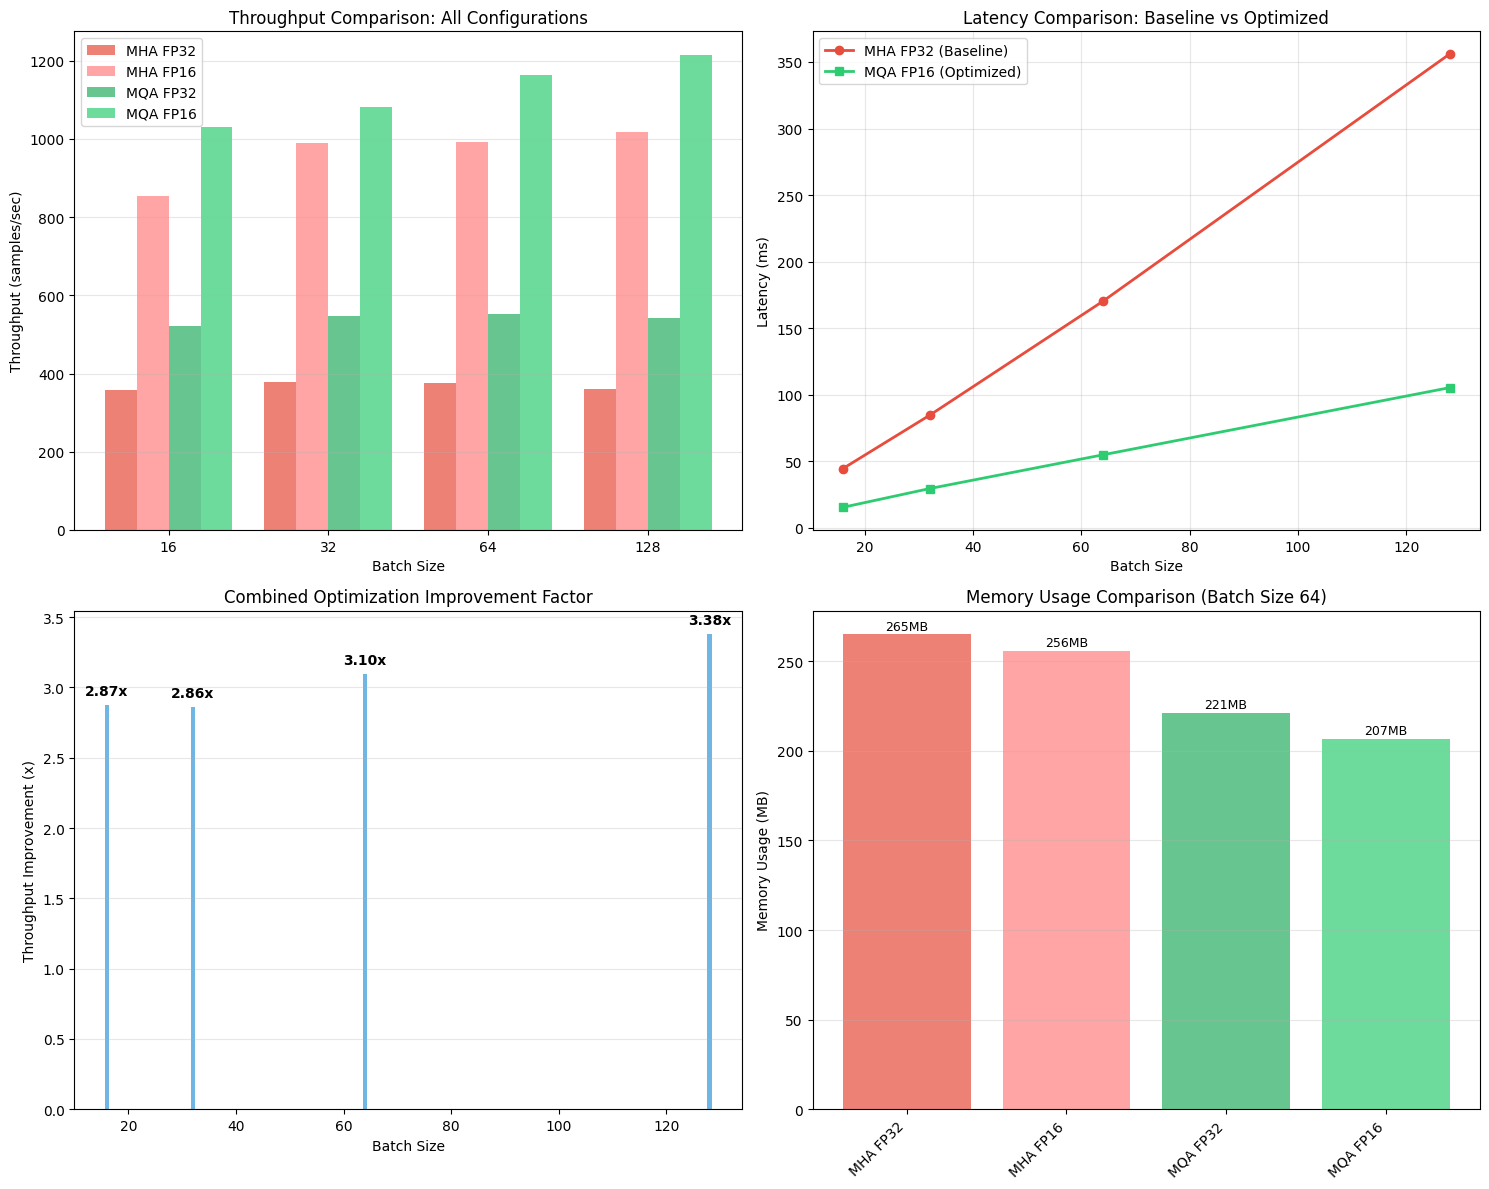


Visualization saved to: assets/exercise2/comprehensive_optimization_results.png


In [19]:
def visualize_performance_comparison():
    """Create comprehensive visualization of optimization results"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    batch_sizes_list = list(benchmark_results.keys())
    
    # Throughput comparison - all configurations
    mha_fp32_throughputs = [benchmark_results[bs]["MHA FP32"]['throughput'] for bs in batch_sizes_list]
    mha_fp16_throughputs = [benchmark_results[bs]["MHA FP16"]['throughput'] for bs in batch_sizes_list]
    mqa_fp32_throughputs = [benchmark_results[bs]["MQA FP32"]['throughput'] for bs in batch_sizes_list]
    mqa_fp16_throughputs = [benchmark_results[bs]["MQA FP16"]['throughput'] for bs in batch_sizes_list]
    
    x = np.arange(len(batch_sizes_list))
    width = 0.2
    
    ax1.bar(x - 1.5*width, mha_fp32_throughputs, width, label='MHA FP32', color='#e74c3c', alpha=0.7)
    ax1.bar(x - 0.5*width, mha_fp16_throughputs, width, label='MHA FP16', color='#ff7f7f', alpha=0.7)
    ax1.bar(x + 0.5*width, mqa_fp32_throughputs, width, label='MQA FP32', color='#27ae60', alpha=0.7)
    ax1.bar(x + 1.5*width, mqa_fp16_throughputs, width, label='MQA FP16', color='#2ecc71', alpha=0.7)
    
    ax1.set_xlabel('Batch Size')
    ax1.set_ylabel('Throughput (samples/sec)')
    ax1.set_title('Throughput Comparison: All Configurations')
    ax1.set_xticks(x)
    ax1.set_xticklabels(batch_sizes_list)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Latency comparison - baseline vs optimized
    baseline_latencies = [benchmark_results[bs]["MHA FP32"]['latency_ms'] for bs in batch_sizes_list]
    optimized_latencies = [benchmark_results[bs]["MQA FP16"]['latency_ms'] for bs in batch_sizes_list]
    
    ax2.plot(batch_sizes_list, baseline_latencies, marker='o', linewidth=2, label='MHA FP32 (Baseline)', color='#e74c3c')
    ax2.plot(batch_sizes_list, optimized_latencies, marker='s', linewidth=2, label='MQA FP16 (Optimized)', color='#2ecc71')
    ax2.set_xlabel('Batch Size')
    ax2.set_ylabel('Latency (ms)')
    ax2.set_title('Latency Comparison: Baseline vs Optimized')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Improvement factors
    improvements = [benchmark_results[bs]["MQA FP16"]['throughput'] / benchmark_results[bs]["MHA FP32"]['throughput'] 
                   for bs in batch_sizes_list]
    
    bars = ax3.bar(batch_sizes_list, improvements, color='#3498db', alpha=0.7)
    ax3.set_xlabel('Batch Size')
    ax3.set_ylabel('Throughput Improvement (x)')
    ax3.set_title('Combined Optimization Improvement Factor')
    ax3.grid(axis='y', alpha=0.3)
    
    # Add improvement values on bars
    for i, v in enumerate(improvements):
        ax3.text(batch_sizes_list[i], v + 0.05, f'{v:.2f}x', ha='center', va='bottom', fontweight='bold')
    
    # Memory efficiency comparison (batch size 64)
    batch_64_results = benchmark_results[64]
    memory_configs = ["MHA FP32", "MHA FP16", "MQA FP32", "MQA FP16"]
    memory_usage = [batch_64_results[config]['avg_memory_mb'] for config in memory_configs]
    colors = ['#e74c3c', '#ff7f7f', '#27ae60', '#2ecc71']
    
    bars = ax4.bar(memory_configs, memory_usage, color=colors, alpha=0.7)
    ax4.set_ylabel('Memory Usage (MB)')
    ax4.set_title('Memory Usage Comparison (Batch Size 64)')
    ax4.set_xticklabels(memory_configs, rotation=45, ha='right')
    ax4.grid(axis='y', alpha=0.3)
    
    # Add memory values on bars
    for bar, mem_val in zip(bars, memory_usage):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{mem_val:.0f}MB', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'comprehensive_optimization_results.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nVisualization saved to: {output_dir}/comprehensive_optimization_results.png")

# Create comprehensive visualization
visualize_performance_comparison()

> **TODO: Architecture recommendation analysis**
> 
> Using your benchmark results _(3.10x combined improvement, 1.47x architecture gain, 2.64x mixed precision gain, 22% memory reduction)_, recommend the optimal configuration for each scenario below, following the example scenario provided. 
> <br> Give a one-sentence justification based on the performance characteristics you measured.
> 
> 
> **Example scenario:** High-volume social media monitoring
> 
> - Requirements: Process 50,000 posts/minute across 10 T4 GPUs, minimize cloud costs
> - Current bottleneck: Infrastructure costs too high with current throughput
> 
>   Your recommendation: MQA + FP16
>   <br>
>   Reasoning: The 3.10x combined throughput improvement allows processing the same 50,000 posts/minute with just 3-4 T4 instances instead of 10, dramatically reducing cloud infrastructure costs.
> 
> **Scenarios to analyze:**
> 
> 1\. Real-time gaming chat moderation
> 
> - Requirements: <25ms response time, handle sudden traffic spikes during tournaments
> - Current bottleneck: Latency spikes cause poor user experience during peak gaming hours
> 
>   Your recommendation: MQA + FP16
>   <br>
>   Reasoning: The combined optimization reduces batch 64 latency from 170.3ms → 55.0ms, giving enough headroom to meet the <25ms target per request when accounting for batching and peak traffic.
> 
> 2\. Research lab experimental setup
> 
> - Requirements: Maximum model accuracy for new NLP research, unlimited A100 GPU access
> - Current focus: Exploring attention mechanisms, accuracy is paramount over efficiency
> 
>   Your recommendation: MHA FP32
>   <br>
>   Reasoning: Prioritizing maximum model accuracy without architectural modifications or mixed precision avoids any potential trade-offs, making FP32 the safest choice for new NLP research.
> 
> 3\. Mobile content filtering app
> 
> - Requirements: Run on smartphones with 4GB RAM, battery-efficient inference
> - Current bottleneck: App crashes due to memory limits on mid-range devices
> 
>   Your recommendation: MQA + FP16
>   <br>
>   Reasoning: Combined optimization reduces memory usage by 22% (265MB → 206.6MB) and increases throughput 3.10x, ensuring the app fits within 4GB RAM while maximizing battery-efficient inference.
> 
> 4\. Edge IoT device deployment
> 
> - Requirements: Process sensor data on Jetson Nano (4GB RAM), 5W power budget
> - Current bottleneck: Model too large and power-hungry for continuous operation
> 
>   Your recommendation: MQA FP32
>   <br>
>   Reasoning: Architecture optimization alone reduces memory by 16.6% and increases throughput 1.47x, keeping the model within 4GB RAM and a 5W power budget without the added complexity of mixed precision.
> 
> 5\. Enterprise API with SLA requirements
> 
> - Requirements: 99.9% uptime, <100ms response time, cost-efficient scaling
> - Current bottleneck: Current 170ms latency violates SLA, causing contract penalties
> 
>   Your recommendation: MQA + FP16
>   <br>
>   Reasoning: Combined optimization cuts latency from 170.3ms → 55.0ms and increases throughput 3.10x, meeting <100ms SLA while reducing the number of GPU instances needed for cost-efficient scaling.
> 
> **Reflection questions:**
> 
> - Which optimization (architecture vs mixed precision) provides the larger performance gain?
> - How does the 22% memory reduction impact deployment decisions?
> - When might you choose MQA FP32 over MHA FP16 despite lower throughput?

## Conclusion

In this exercise, you've implemented and compared attention architectures to gain a hands-on understanding of the relationship between transformer architecture choices and GPU hardware efficiency. 

**Key insight**: Modern transformer performance is often limited by memory bandwidth rather than computational capacity. Architecture choices like MQA that reduce memory traffic while preserving computational patterns can unlock dramatic performance improvements without requiring additional hardware.

The architectural principles you've learned—shared projections, memory-efficient attention patterns, and systematic hardware impact analysis—plus the use of hardware acceleration such as tensor cores, apply broadly to transformer optimization and are essential for cost-effective deployment of language models in production environments.

##### **Next optimization challenges to explore:**

- **Grouped Query Attention (GQA)**: Implement the middle ground between MHA and MQA with configurable key/value sharing

- **Advanced profiling techniques:** Use PyTorch Profiler to identify micro-optimizations in attention kernels

- **Memory optimization strategies**: Explore gradient checkpointing and activation recomputation for longer sequences

- **Multi-GPU attention scaling**: Implement tensor parallelism for attention across multiple GPUs